In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

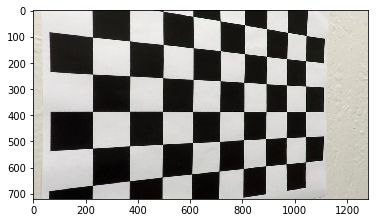

In [58]:
class Camera:
    def __init__(self, path_to_imgs, chessboard_dim):
        self.isCalibrated = False
        images = glob.glob(path_to_imgs)
        obj_pts = np.zeros((chessboard_dim[0] * chessboard_dim[1], 3), np.float32)
        obj_pts[:, :2] = np.mgrid[0 : chessboard_dim[0], 0 : chessboard_dim[1]].T.reshape(-1, 2)
        
        obj_set = []
        img_set = []
        for image in images:
            gray = cv2.cvtColor(mpimg.imread(image), cv2.COLOR_RGB2GRAY)
            ret, img_pts = cv2.findChessboardCorners(gray, chessboard_dim, None)
            if ret:
                img_set.append(img_pts)
                obj_set.append(obj_pts)
        if img_set:
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_set, img_set, gray.shape[::-1], None, None)
            if ret:
                self.isCalibrated = True
                self.__mtx = mtx
                self.__dist = dist
                self.__cb_dir = path_to_imgs
                self.__cb_dim = chessboard_dim
    def correctDistortion(self, img):
        if self.isCalibrated:
            return cv2.undistort(img, self.__mtx, self.__dist)
        else:
            return np.array([])
    def showTestImage(self):
        undist = self.correctDistortion(mpimg.imread(glob.glob(self.__cb_dir)[0]))
        if undist.size:
            plt.imshow(undist)
            plt.savefig("./output_images/01_rawCamera_chessboard_undistorted.png")
        
my_camera = Camera("./camera_cal/calibration*.jpg", (9, 6))
my_camera.showTestImage()


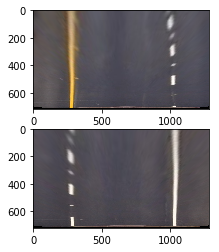

In [59]:
class MountingPerspective():
    def manual_setup(self):
        img = mpimg.imread("./test_images/straight_lines1.jpg")
        real_camera = Camera("./camera_cal/calibration*.jpg", (9, 6))
        undist = real_camera.correctDistortion(img)
        # this is supposedly done offline.
        plt.imshow(undist)
    def __init__(self):
        src = np.float32([
            [282, 670],
            [595, 451],
            [690, 451],
            [1034, 670],
        ])
        dst = np.float32([
            [282, 700],
            [282, 100],
            [1034, 100],
            [1034, 700],
        ])
        self.__M = cv2.getPerspectiveTransform(src, dst)
        self.__Minv = cv2.getPerspectiveTransform(dst, src)
    def correctPerspective(self, img):
        dim = img.shape[:2]
        return cv2.warpPerspective(img, self.__M, dim[::-1], flags = cv2.INTER_LINEAR)
    def reversePerspective(self, img):
        return cv2.warpPerspective(img, self.__Minv, dim[::-1], flags = cv2.INTER_LINEAR)

# %matplotlib notebook
# my_camera = Camera("./camera_cal/calibration*.jpg", (9, 6))
my_mounting = MountingPerspective()
# mounting.manual_setup()

img = mpimg.imread("./test_images/straight_lines1.jpg")
undist = my_camera.correctDistortion(img)
birdview1 = my_mounting.correctPerspective(undist)

img = mpimg.imread("./test_images/straight_lines2.jpg")
undist = my_camera.correctDistortion(img)
birdview2 = my_mounting.correctPerspective(undist)

h, (ax0, ax1) = plt.subplots(2, 1)
ax0.imshow(birdview1)
ax1.imshow(birdview2)
plt.savefig("./output_images/02_mountedCamera_straightlines_undistorted_and_perspective.png")